In [34]:
import sys
sys.path.append('../')

import os
import json
import time

from glob import glob
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from utils.elastix import excute_cmd, register_elastix, control_points_transformix
from utils.filemanager import create_directory_if_not_exists, replace_text_in_file, add_and_delete_rows, delete_added_rows
from utils.niftimanager import load_nifti, show_nifti
from utils.landmarks import get_landmarks_from_txt, write_landmarks_to_list
from utils.logger import pprint_objects
from utils.metrics import compute_TRE
from utils.utils import format_elapsed_time
from utils.dataset import segment_lungs_and_remove_trachea, display_volumes, create_mask

# To allow auto reload to this notebook after modifying any external file imported
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
train_path = '../niftiData'

# prepare the paths
exhale_volumes = [path.replace('\\', '/') for path in sorted(glob(os.path.join(train_path, "***" , "*eBHCT.nii.gz"), recursive=True))]
inhale_volumes = [path.replace('\\', '/') for path in sorted(glob(os.path.join(train_path, "***" , "*iBHCT.nii.gz"), recursive=True))]

In [3]:
exhale_volumes

['../niftiData/copd1/copd1_eBHCT.nii.gz',
 '../niftiData/copd2/copd2_eBHCT.nii.gz',
 '../niftiData/copd3/copd3_eBHCT.nii.gz',
 '../niftiData/copd4/copd4_eBHCT.nii.gz']

In [78]:
def display_results(e_nifti, initial_mask, labeled_mask, largest_mask_1, final_mask_no_trachea, slice_index):
    plt.figure(figsize=(20, 11))

    plt.subplot(151)
    plt.imshow(e_nifti[slice_index,:,:], cmap='gray')
    plt.title('e_nifti')

    plt.subplot(152)
    plt.imshow(initial_mask[slice_index,:,:], cmap='gray')
    plt.title('initial_mask')

    plt.subplot(153)
    plt.imshow(labeled_mask[slice_index,:,:], cmap='viridis')
    plt.title('labeled_mask')

    plt.subplot(154)
    plt.imshow(largest_mask_1[slice_index,:,:], cmap='viridis')
    plt.title('largest_mask_1')

    plt.subplot(155)
    plt.imshow(final_mask_no_trachea[slice_index,:,:], cmap='viridis')
    plt.title(f'Processed without Trachea {slice_index}')

    plt.show()

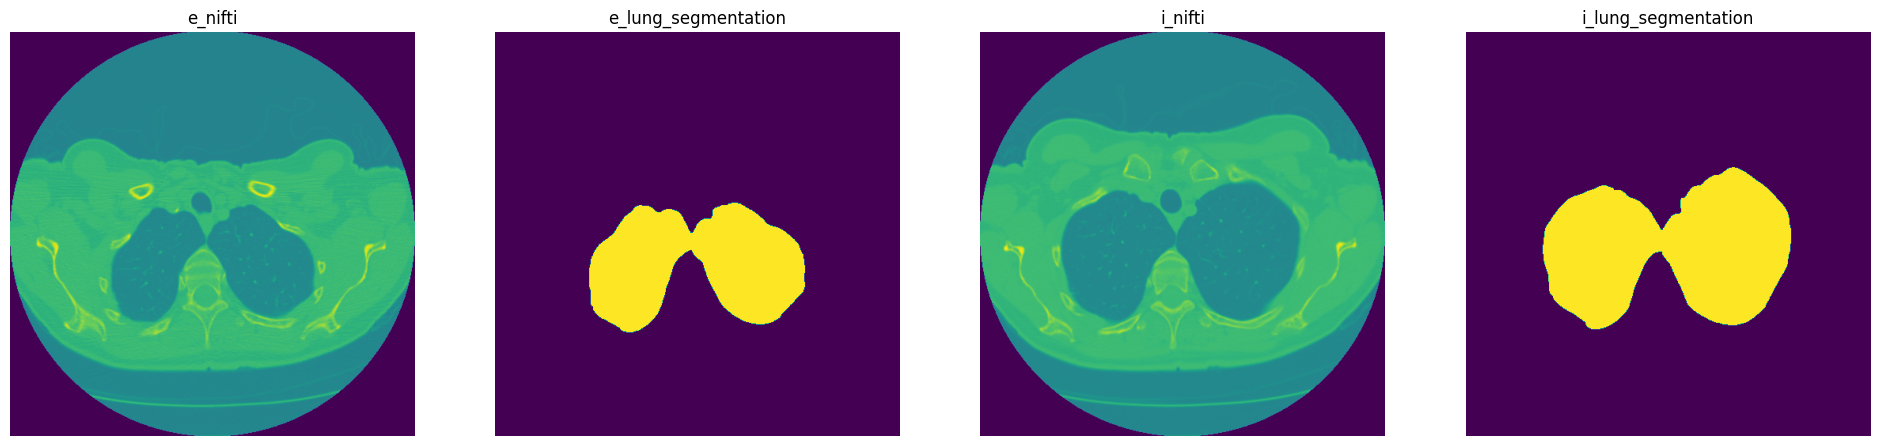

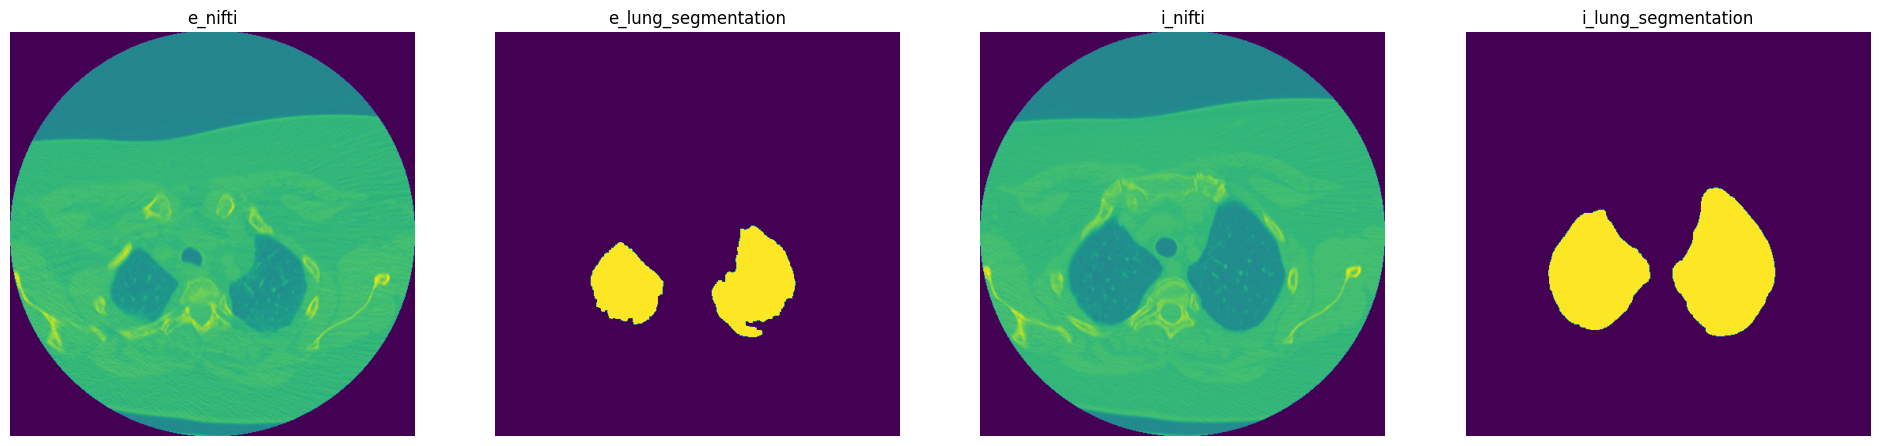

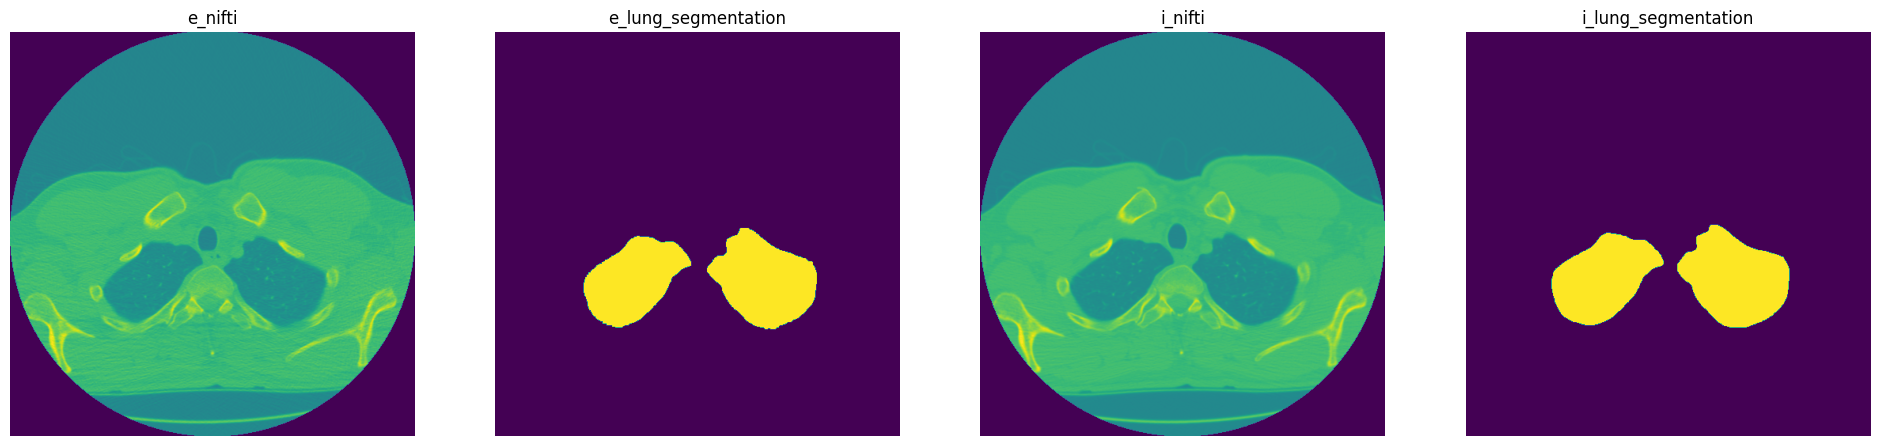

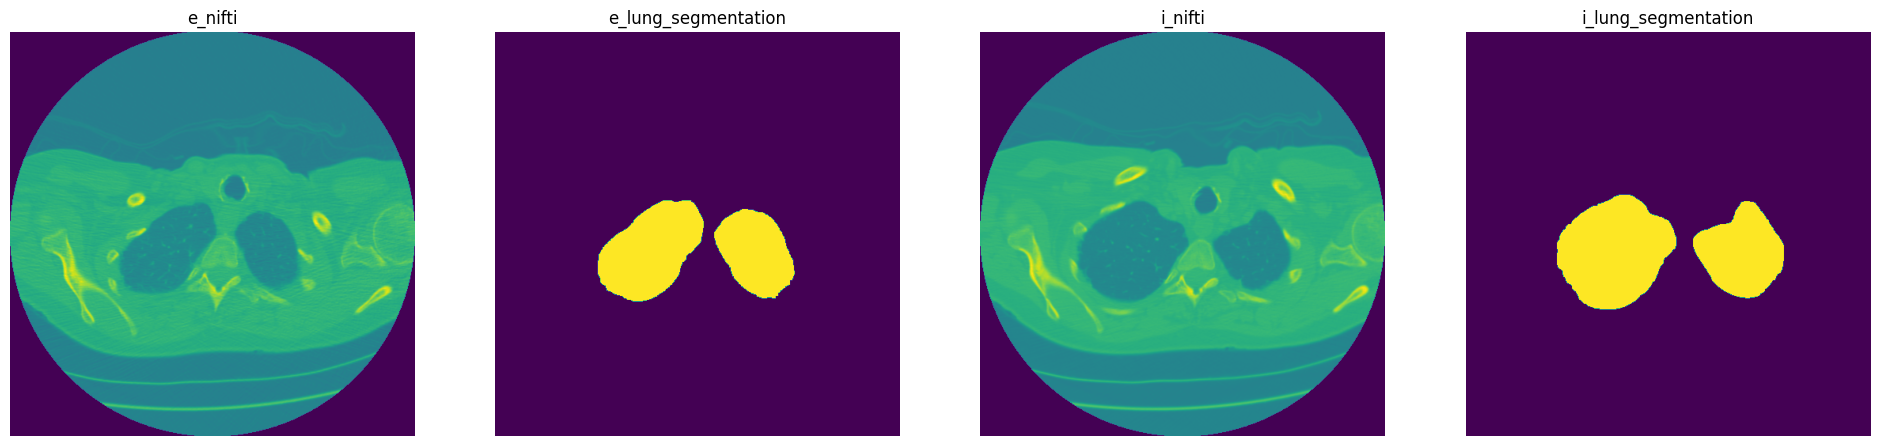

In [103]:
for e_path, i_path in zip(exhale_volumes, inhale_volumes):
    
    # get file name
    e_filename_full = e_path.split('/')[-1].split('.')[0] #copd1_eBHCT, ..
    i_filename_full = i_path.split('/')[-1].split('.')[0] #copd1_iBHCT, ..

    sample_name = i_path.split('/')[-1].split('_')[0] #copd1, copd2, ...

    # load the nifti volumes
    e_nifti = load_nifti(e_path)[0]
    i_nifti = load_nifti(i_path)[0]

    # set a specific threshold to copd2
    if sample_name == 'copd2':
        threshold = 400
    else:
        threshold = 700 

    # segment the lungs from the nifti volumes
    _, _, _, e_lung_segmentation = \
        segment_lungs_and_remove_trachea(e_nifti, 
                                         threshold=threshold)
    _, _, _, i_lung_segmentation = segment_lungs_and_remove_trachea(
        i_nifti, 
        threshold=threshold
        )

    display_volumes(
        e_nifti, 
        e_lung_segmentation, 
        i_nifti, 
        i_lung_segmentation,
        title1 = 'e_nifti',
        title2 = 'e_lung_segmentation',
        title3 = 'i_nifti',
        title4 = 'i_lung_segmentation',
        slice1 = 15, # e_nifti.shape[0]//2,
        slice2 = 15, # e_lung_segmentation.shape[0]//2,
        slice3 = 15, # i_nifti.shape[0]//2,
        slice4 = 15, # i_lung_segmentation.shape[0]//2,
        )

In [ ]:


    # display_volumes(
    #     e_nifti, 
    #     e_lung_segmentation, 
    #     i_nifti, 
    #     # i_lung_segmentation,
    #     title1 = 'Exhale',
    #     title2 = 'Exhale Segmentation',
    #     title3 = 'Inhale',
    #     # title4 = 'Inhale Segmentation',
    #     slice1 = 50,
    #     slice2 = 50,
    #     slice3 = 50,
    #     # slice4 = 50
    #     )
    
    # # Flatten the image to a 1D array
    # flattened_image = e_nifti.ravel()

    # # Plot the histogram
    # plt.hist(flattened_image, bins=256, range=(0, 3000), density=True, color='gray', alpha=0.75)
    # plt.title(f'Histogram of {e_filename_full}')
    # plt.xlabel('Pixel Value')
    # plt.ylabel('Frequency')
    # plt.grid(True)
    # plt.show()

    # plt.imshow(e_mask[50, :, :,], cmap='gray')